# Special topics

In this notebook we'll explore a few different topics that are of interest to A/B testing. It might seem like a hodge podge of ideas, but they do all really come together when you analyze experiments. 

## 1. Central Limit Theorem

Why can we use the normal approximation for so many types of metrics? It's because we can assume that even if the metric itself is not normally distributed, its _mean_ will be. And since most of the time we are interested in the Average Treatment Effect (i.e. how much being in the test group affects X behavior _on average_), we can just assume the distribution of the sample means will be approximately normal. 

Let's demonstrate!

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(14, 8)}
sns.set_theme(style="whitegrid", rc=custom_params, palette='bright')

In [7]:
# Let's generate some data that is exponentially distributed https://en.wikipedia.org/wiki/Exponential_distribution

# rate parameter for the exponentially distributed population
rate = 0.25

#Population mean
mu = 1/rate

# Population standard deviation
sd = np.sqrt(1/(rate**2))

print('Population mean:', mu)
print('Population standard deviation:', sd)

Population mean: 4.0
Population standard deviation: 4.0


In [8]:
sample_size = 2
df2 = pd.DataFrame(index= ['x1', 'x2'] )

for i in range(50):
    exponential_sample = np.random.exponential((1/rate), sample_size)
    col = f'sample {i+1}'
    df2[col] = exponential_sample

# Taking a peek at the samples
df2

,sample 1,sample 2,sample 3,sample 4,sample 5,sample 6,sample 7,sample 8,sample 9,sample 10,...,sample 41,sample 42,sample 43,sample 44,sample 45,sample 46,sample 47,sample 48,sample 49,sample 50
x1,7.674845,2.505555,0.020955,0.700794,3.927315,1.878941,4.027638,1.181105,1.115819,8.347224,...,8.526173,1.424356,1.573774,1.362741,4.375984,9.048886,4.137615,12.428688,13.450242,2.161471
x2,0.081467,1.371503,13.291038,9.924877,5.966876,4.126211,0.740916,0.101368,4.092659,8.417474,...,5.608339,3.969162,0.460491,2.243184,2.845426,7.213243,0.261656,9.823555,4.889619,0.129626


/Users/tvasilikioti/.pyenv/versions/pyconit/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


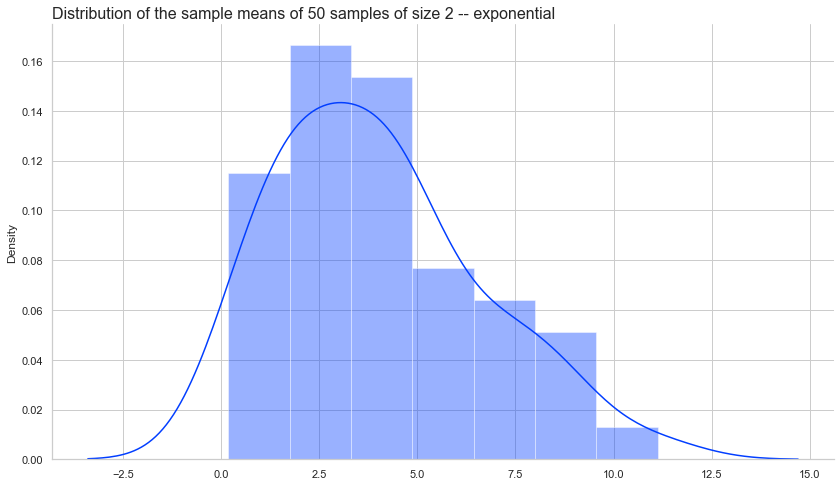

In [9]:
# Calculating sample means and plotting their distribution
df2_sample_means = df2.mean()
sns.distplot(df2_sample_means)
plt.title("Distribution of the sample means of 50 samples of size 2 -- exponential", loc='left', size=16)
plt.show()

/Users/tvasilikioti/.pyenv/versions/pyconit/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


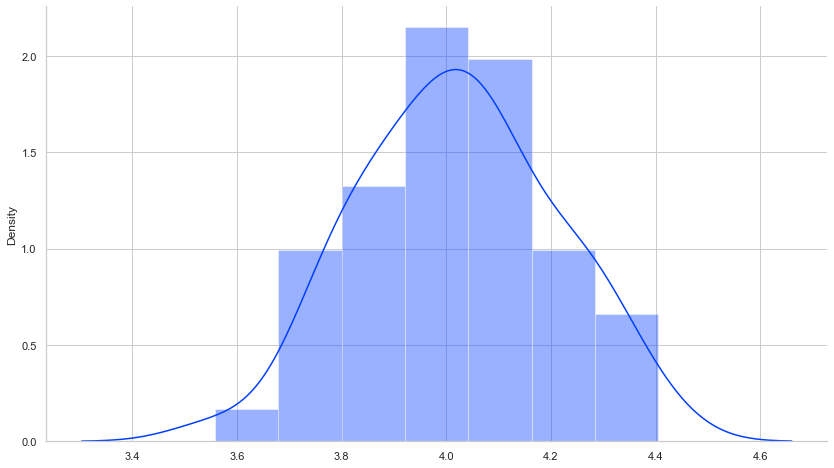

In [10]:
# Now, draw 50 samples of size 500 
sample_size=500

df500 = pd.DataFrame()

for i in range(1, 51):
    exponential_sample = np.random.exponential((1/rate), sample_size)
    col = f'sample {i}'
    df500[col] = exponential_sample


df500_sample_means = pd.DataFrame(df500.mean(),columns=['Sample means'])
sns.distplot(df500_sample_means);

In [11]:
df500_sample_means.mean()

Sample means    4.020324
dtype: float64

In [12]:
mu

4.0

## Testing for other types of metrics

### Example: Mann-Whitney U test for medians

H_0: The two groups are sampled from populations with identical distributions (which means they also have the same median). 

**Practice**

(This exercise is inspired from here: https://www.marsja.se/how-to-perform-mann-whitney-u-test-in-python-with-scipy-and-pingouin/) 

Setup: "You are running an intervention study designed to examine the effectiveness of a new psychological treatment to reduce symptoms of depression in adults. Let’s say that you have a total of n=14 participants. Furthermore, these participants are randomized to receive either the treatment or no treatment, at all. In your study, the participants are asked to record the number of depressive episodes over a 1 week period following receipt of the assigned treatment." Let's create some sample data: 

In [13]:
data = {'no_treatment':[7, 5, 6, 4, 12, 9, 8],
        'treatment':[3, 6, 4, 2, 1, 5, 1]}

# Dictionary to Dataframe
df = pd.DataFrame(data)

In [14]:
df

,no_treatment,treatment
0,7,3
1,5,6
2,6,4
3,4,2
4,12,1
5,9,5
6,8,1


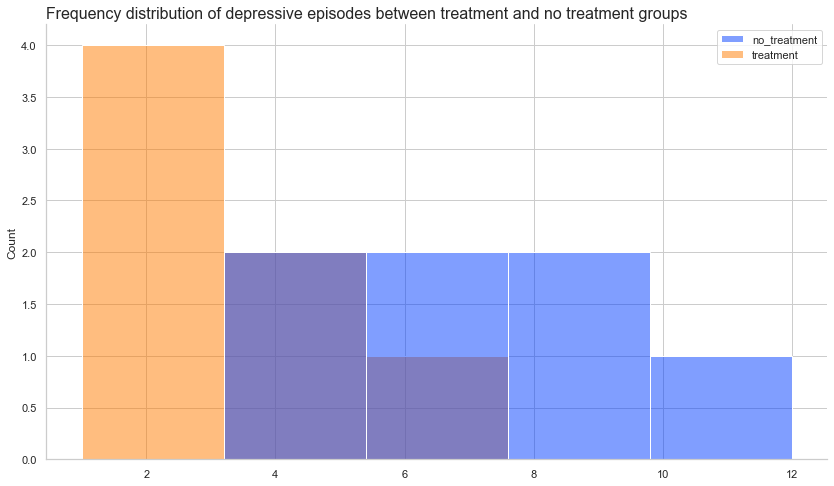

In [15]:
sns.histplot(df)
plt.title("Frequency distribution of depressive episodes between treatment and no treatment groups", 
          loc='left', 
          size=16)
plt.show()

In [21]:
from pingouin import mwu

results = mwu(x=df['no_treatment'], y=df['treatment'], 
              alternative='greater')
results

,U-val,alternative,p-val,RBC,CLES
MWU,44.5,greater,0.006163,-0.816327,0.908163


**What do you conclude from this test?**

In [22]:
df.median()

no_treatment    7.0
treatment       3.0
dtype: float64

## CUPED and variance reduction

CUPED is a technique that allows us to reduce variance in an experiment by using a correlated co-variate to transform the Y (response variable). Usually, the best correlated data will be the pre-experimental data for the same user on the same metric. For example: 

- If y = average session time, we can use what we know about the user's pre-experiment session time so that  x = average session time_pre. 
- By accounting for the differences already known to us before the experiment about those users, we are able to reduce the variance of the experiment metric by removing the variance that has nothing to do with the experiment treatment. 

The below simulation demonstrates how this works in practice. Credit to https://towardsdatascience.com/online-experiments-tricks-variance-reduction-291b6032dcd7 for the simulation code. 

In [24]:
from scipy.stats import pearsonr
from scipy.optimize import minimize

In [26]:
def generate_data(treatment_effect, size):
    """
    Generates A/B test data where the group 1 performs treatment_effect size better. 
    """
    # generate y from a normal distribution
    df = pd.DataFrame({'y': np.random.normal(loc=0, scale=1, size=size)})
    # create a covariate that's corrected with y 
    df['x'] = minimize(
        lambda x: 
        abs(0.95 - pearsonr(df.y, x)[0]), 
        np.random.rand(len(df.y))).x
    # random assign rows to two groups 0 and 1 
    df['group'] = np.random.randint(0,2, df.shape[0])
    # for treatment group add a treatment effect 
    df.loc[df["group"] == 1, 'y'] += treatment_effect
    return df    

df = generate_data(treatment_effect=1, size=1000)
theta = df.cov()['x']['y'] / df.cov()['x']['x']
df['y_cuped'] = df.y - theta * df.x

In [28]:
df.head()

,y,x,group,y_cuped
0,0.024405,0.969949,0,-1.055197
1,1.764753,1.055397,1,0.590043
2,0.428625,-0.240387,1,0.696188
3,0.085722,-0.583979,1,0.735719
4,0.310192,0.722687,0,-0.494195


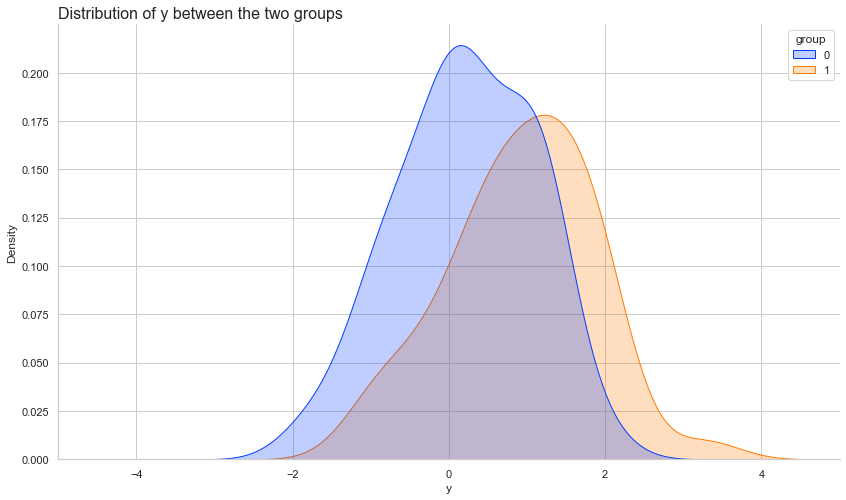

In [57]:
sns.kdeplot('y', hue='group', data=df, shade=True) 
plt.xlim([-5, 5])
plt.title("Distribution of y between the two groups", loc='left', size=16)
plt.show()

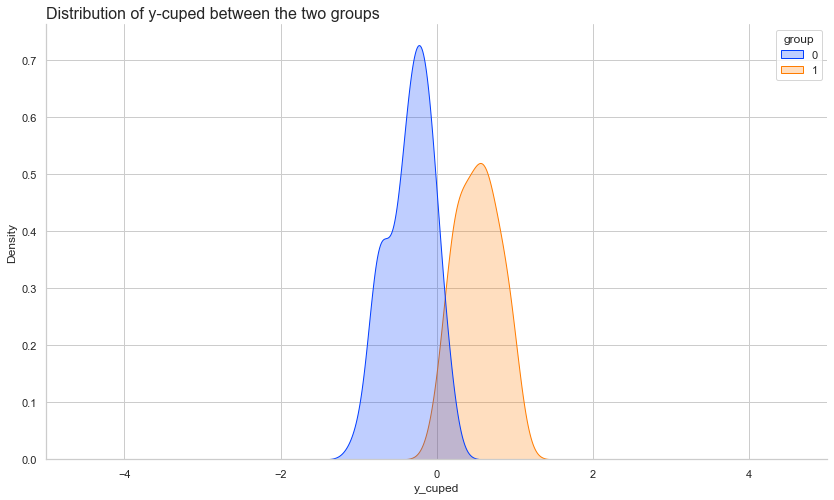

In [55]:
sns.kdeplot('y_cuped', hue='group', data=df, shade=True)
plt.xlim([-5, 5])
plt.title("Distribution of y-cuped between the two groups", loc='left', size=16)
plt.show()

Now that we've seen that we managed to decrease the variance of y, let's see how would the treatment effect be affected!

In [41]:
def meandiff(df: pd.DataFrame) -> float:
    """
    Returns the difference between theh means ys of the test and the control groups.
    """
    return df[df.group==1].y.mean() - df[df.group==0].y.mean()

def cuped_meandiff(df:pd.DataFrame) -> float:
    """
    Returns the difference of the cuped-transformed y means. 
    """
    theta = df.cov()['x']['y'] / df.cov()['x']['x']
    df['y_cuped'] = df.y - theta * df.x
    return df[df.group==1].y_cuped.mean() - df[df.group==0].y_cuped.mean()


meandiff_lst = []
cuped_meandiff_lst = []
for i in range(200):
    df = generate_data(treatment_effect=1, size=100)
    meandiff_lst.append(meandiff(df))
    cuped_meandiff_lst.append(cuped_meandiff(df))

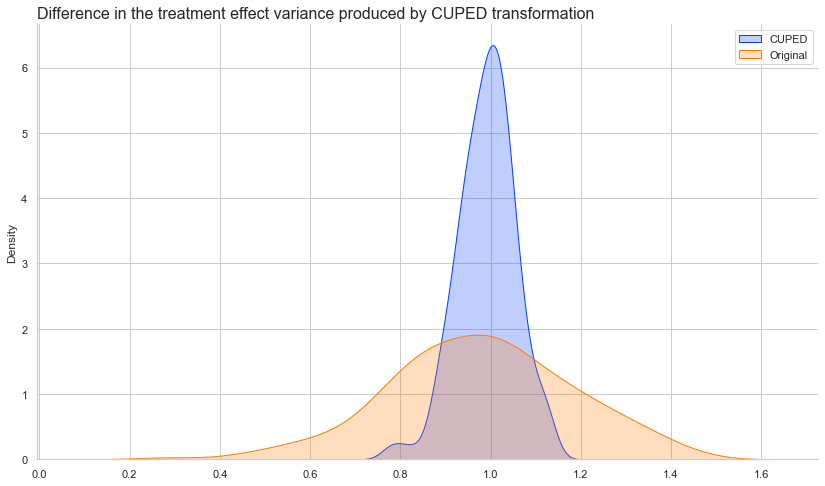

In [58]:
# Now let's plot how we have affected the treatment effect variance!
ax = sns.kdeplot(cuped_meandiff_lst, shade=True, label='CUPED')
sns.kdeplot(meandiff_lst, shade=True, label='Original', ax=ax)
plt.legend()
plt.title("Difference in the treatment effect variance produced by CUPED transformation", 
          loc='left', 
          size=16)
plt.show()